# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [ ]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

Default GPU Device: /device:GPU:0


In [ ]:
# URL didn't work so downloading the dataset manually

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

# Upload file manually
from google.colab import files
uploaded = files.upload()

# Load the file
text = load_dataset('mark_twain.txt', fraction=1.0)

Saving mark_twain.txt to mark_twain.txt


# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [ ]:
# Load the dataset
file_name = "mark_twain.txt"  # Ensure file name matches the uploaded file
with open(file_name, 'r', encoding='utf-8') as file:
    text = file.read()

# Explore the dataset
# Print the first 1000 characters
print("First 1000 characters of the dataset:\n")
print(text[:1000])

# Report dataset size (total characters)
dataset_size = len(text)
print(f"\nDataset size: {dataset_size} characters")

# Count and display unique characters
unique_characters = set(text)
num_unique_characters = len(unique_characters)
print(f"Number of unique characters: {num_unique_characters}")
print(f"Unique characters: {sorted(unique_characters)}")

First 1000 characters of the dataset:


The Project Gutenberg EBook of The Prince and The Pauper, Complete by
Mark Twain (Samuel Clemens)

This eBook is for the use of anyone anywhere at no cost and with almost
no restrictions whatsoever. You may copy it, give it away or re-use
it under the terms of the Project Gutenberg License included with this
eBook or online at www.gutenberg.org

Title: The Prince and The Pauper, Complete

Author: Mark Twain (Samuel Clemens)

Release Date: August 20, 2006 [EBook #1837]
Last Updated: February 19, 2018

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK PRINCE AND THE PAUPER ***

Produced by David Widger. The earliest PG edition was prepared by Les
Bowler




THE PRINCE AND THE PAUPER

by Mark Twain

The Great Seal

I will set down a tale as it was told to me by one who had it of his
father, which latter had it of HIS father, this last having in like
manner had it of HIS father--and so on, back and still back

## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [ ]:
# Define start and end markers
start_marker = "*** START OF THIS PROJECT GUTENBERG EBOOK"
end_marker = "*** END OF THIS PROJECT GUTENBERG EBOOK"

# Find indices of the main content
start_idx = text.find(start_marker) + len(start_marker)
end_idx = text.find(end_marker)

# Extract main content
if start_idx == -1 or end_idx == -1:
    print("\nError: Could not locate start or end markers. Please check the text structure.")
    main_text = ""
else:
    main_text = text[start_idx:end_idx].strip()

# Preview extracted content
print("\nExtracted content preview (first 500 characters):\n")
print(main_text[:500])
print(f"\nExtracted content size: {len(main_text)} characters")


Extracted content preview (first 500 characters):

PRINCE AND THE PAUPER ***

Produced by David Widger. The earliest PG edition was prepared by Les
Bowler




THE PRINCE AND THE PAUPER

by Mark Twain

The Great Seal

I will set down a tale as it was told to me by one who had it of his
father, which latter had it of HIS father, this last having in like
manner had it of HIS father--and so on, back and still back, three
hundred years and more, the fathers transmitting it to the sons and so
preserving it.  It may be history, it may be only a legend,

Extracted content size: 396114 characters


In [ ]:
import re

# Clean the extracted text
main_text = re.sub(r'\[.*?\]', '', main_text)  # Remove text in square brackets
main_text = re.sub(r'[^\w\s]', '', main_text)  # Remove punctuation
main_text = re.sub(r'\s+', ' ', main_text).strip()  # Normalize whitespace

# Display a preview of the cleaned text
print("\nCleaned text preview (first 500 characters):\n")
print(main_text[:500])
print(f"\nCleaned dataset size: {len(main_text)} characters")


Cleaned text preview (first 500 characters):

PRINCE AND THE PAUPER Produced by David Widger The earliest PG edition was prepared by Les Bowler THE PRINCE AND THE PAUPER by Mark Twain The Great Seal I will set down a tale as it was told to me by one who had it of his father which latter had it of HIS father this last having in like manner had it of HIS fatherand so on back and still back three hundred years and more the fathers transmitting it to the sons and so preserving it It may be history it may be only a legend a tradition It may have

Cleaned dataset size: 376109 characters


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Initialize the tokenizer
VOCAB_SIZE = None  # Use all unique words
OOV_TOKEN = '<OOV>'
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)

# Fit the tokenizer on cleaned text
tokenizer.fit_on_texts([main_text])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences([main_text])[0]

# Extract word index
word_index = tokenizer.word_index

# Display tokenization results
print(f"\nVocabulary size: {len(word_index)} (including OOV token)")
print(f"Sample word-to-index mapping: {dict(list(word_index.items())[:10])}")  # Show first 10 mappings
print(f"Sample tokenized sequence (first 20 tokens): {sequences[:20]}")


Vocabulary size: 8658 (including OOV token)
Sample word-to-index mapping: {'<OOV>': 1, 'the': 2, 'and': 3, 'of': 4, 'to': 5, 'a': 6, 'he': 7, 'his': 8, 'in': 9, 'was': 10}
Sample tokenized sequence (first 20 tokens): [54, 3, 2, 471, 2752, 28, 2753, 4067, 2, 4068, 4069, 4070, 10, 1660, 28, 4071, 4072, 2, 54, 3]


If everything worked, the following line should show you the first 10 words in the vocabulary:

In [ ]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<OOV>', 1), ('the', 2), ('and', 3), ('of', 4), ('to', 5), ('a', 6), ('he', 7), ('his', 8), ('in', 9), ('was', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [ ]:
SEQ_LENGTH = 50

# Convert the tokenized text into a list of sequences of numbers
# Assuming `main_text` is the cleaned text from earlier preprocessing
tokenized_text = tokenizer.texts_to_sequences([main_text])[0]

# Generate sequences of SEQ_LENGTH + 1 tokens
sequences = []
for i in range(SEQ_LENGTH, len(tokenized_text)):
    seq = tokenized_text[i - SEQ_LENGTH : i + 1]
    sequences.append(seq)

# Initialize X and y
X = []
y = []

# Populate X and y from sequences
for seq in sequences:
    X.append(seq[:-1])  # Input is the first SEQ_LENGTH tokens
    y.append(seq[-1])   # Target is the last token in the sequence

print(f"Number of sequences created: {len(sequences)}")
print(f"Sample sequence (X[0]): {X[0]} -> Target (y[0]): {y[0]}")

Number of sequences created: 69971
Sample sequence (X[0]): [54, 3, 2, 471, 2752, 28, 2753, 4067, 2, 4068, 4069, 4070, 10, 1660, 28, 4071, 4072, 2, 54, 3, 2, 471, 28, 611, 2754, 2, 82, 272, 15, 42, 214, 93, 6, 817, 25, 11, 10, 612, 5, 36, 28, 50, 59, 24, 11, 4, 8, 134, 57, 1200] -> Target (y[0]): 24


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [ ]:
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [54, 3, 2, 471, 2752, 28, 2753, 4067, 2, 4068, 4069, 4070, 10, 1660, 28, 4071, 4072, 2, 54, 3, 2, 471, 28, 611, 2754, 2, 82, 272, 15, 42, 214, 93, 6, 817, 25, 11, 10, 612, 5, 36, 28, 50, 59, 24, 11, 4, 8, 134, 57, 1200]
Target: 24
Translated back to words: ['prince', 'and', 'the', 'pauper', 'produced', 'by', 'david', 'widger', 'the', 'earliest', 'pg', 'edition', 'was', 'prepared', 'by', 'les', 'bowler', 'the', 'prince', 'and', 'the', 'pauper', 'by', 'mark', 'twain', 'the', 'great', 'seal', 'i', 'will', 'set', 'down', 'a', 'tale', 'as', 'it', 'was', 'told', 'to', 'me', 'by', 'one', 'who', 'had', 'it', 'of', 'his', 'father', 'which', 'latter'] -> had


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
    if OOV_TOKEN in tokenizer.word_index:
        mask = y != tokenizer.word_index[OOV_TOKEN]
        X = X[mask]
        y = y[mask]

    # One-hot encode the target token
    y = to_categorical(y, num_classes=VOCAB_SIZE)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")


X_train shape: (55976, 50)
y_train shape: (55976, 8659)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

VOCAB_SIZE = len(tokenizer.word_index) + 1    # Vocab size (+1 for padding/OOV)
EMBEDDING_DIM = 100                           # Size of embedding vectors
LSTM_UNITS = 256                              # Number of LSTM units
DROPOUT_RATE = 0.2                            # Dropout rate for regularization

# Define the model
model = Sequential([
    # Embedding layer: maps input tokens to dense vectors
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_shape=(SEQ_LENGTH,)),

    # LSTM layer: captures sequence dependencies
    LSTM(LSTM_UNITS, return_sequences=False),

    # Dropout layer: prevents overfitting
    Dropout(DROPOUT_RATE),

    # Dense output layer: predicts the next token
    Dense(VOCAB_SIZE, activation='softmax')
])

# Check if model has layers and print summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 100)             │         865,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 256)                 │         365,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8659)                │       2,225,363 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,456,831 (13.19 MB)

 Trainable params: 3,456,831 (13.19 MB)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

_your explanation here_

In [ ]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',  # Multi-class classification loss
    optimizer='adam',                 # Adaptive learning rate optimizer
    metrics=['accuracy']              # Track accuracy during training
)

print("Model compiled successfully!")

Model compiled successfully!


## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [ ]:
# Training parameters
BATCH_SIZE = 128
EPOCHS = 5

# Train model and store the results
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1                        # Display progress during training
)

print("Model training complete!")

Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.0590 - loss: 7.2273 - val_accuracy: 0.0670 - val_loss: 6.6916
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.0740 - loss: 6.4556 - val_accuracy: 0.0842 - val_loss: 6.5998
Epoch 3/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.0892 - loss: 6.2099 - val_accuracy: 0.0916 - val_loss: 6.5573
Epoch 4/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.1044 - loss: 6.0153 - val_accuracy: 0.0995 - val_loss: 6.5315
Epoch 5/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.1137 - loss: 5.7796 - val_accuracy: 0.1033 - val_loss: 6.5091
Model training complete!


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

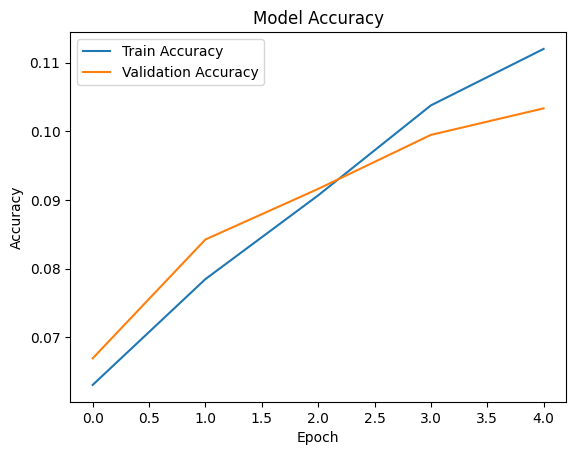

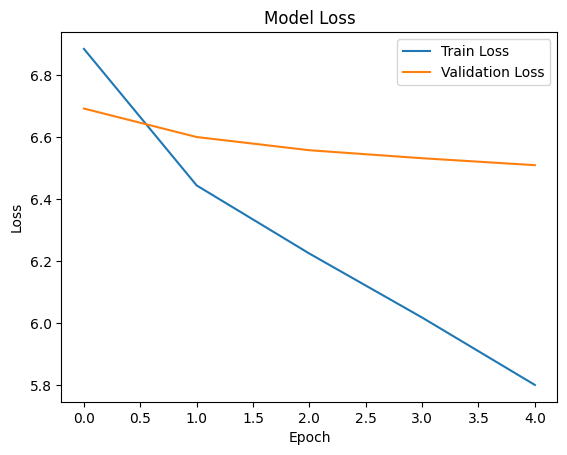

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

def get_predicted_word(model, sequence):
    """
    Get the predicted word from the model.
    This helper function uses a concept we haven't covered in class yet: temperature.
    In essence, a little bit of randomness in what word we predict can make the text more interesting.
    """

    # Use model to predict the next token in the sequence
    yhat = model.predict(sequence, verbose=0)

    # Get the index of the predicted word, according to probabilities
    yhat = np.random.choice(range(VOCAB_SIZE), p=yhat.ravel())

    return yhat

def generate_text(model, tokenizer, seed_text, max_sequence_len, num_words_to_generate=50):
    """
    Generate new text using the trained model.
    You can use the `get_predicted_word` helper function to help you with this.
    """
    # Start with the seed text
    generated_text = seed_text

    for _ in range(num_words_to_generate):
        # Tokenize and pad the seed text
        tokenized_sequence = tokenizer.texts_to_sequences([generated_text])[0]
        padded_sequence = pad_sequences([tokenized_sequence], maxlen=max_sequence_len, padding='pre')

        # Get the predicted word index using helper function
        predicted_token_id = get_predicted_word(model, padded_sequence)

        # Convert token ID to word
        predicted_word = tokenizer.index_word.get(predicted_token_id, '<OOV>')

        # Stop if predicted word is <OOV>
        if predicted_word == '<OOV>':
            break

        # Append the predicted word to the generated text
        generated_text += ' ' + predicted_word

    return generated_text

In [ ]:
# Test the text generation function

seed_text = "Once upon a time"
max_sequence_len = SEQ_LENGTH
generated_text = generate_text(model, tokenizer, seed_text, max_sequence_len, num_words_to_generate=50)

print("Generated Text:")
print(generated_text)


Generated Text:
Once upon a time might not my hunger in be cheer legs this have quite proud is searching their become her forbid holy name arm we to thee she cause be quarters i joy what fear his mind he was her people account it to a sort of hughs presence of the region followed


It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small.

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras.
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [ ]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2024-12-06 03:04:52--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.74MB/s    in 3m 0s   

2024-12-06 03:07:53 (4.58 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
# Load the pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [ ]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [ ]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    embedding_layer = Embedding(
        VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False
    )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Reinitialize tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

if 'tokenizer' not in locals():
    tokenizer = Tokenizer(num_words=None, oov_token='<OOV>')      # Initialize the tokenizer
    tokenizer.fit_on_texts([main_text])                           # Fit on the cleaned text

# Ensure VOCAB_SIZE and SEQ_LENGTH are set
VOCAB_SIZE = len(tokenizer.word_index) + 1
SEQ_LENGTH = 50

# Define and train the model
if VOCAB_SIZE is None or SEQ_LENGTH is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Define the refined model
    refined_model = Sequential([
        embedding_layer,                                          # Use the pre-trained embedding layer
        LSTM(256, return_sequences=False),                        # LSTM layer with 256 units
        Dropout(0.2),                                             # Dropout layer for regularization
        Dense(VOCAB_SIZE, activation='softmax')                   # Dense output layer for predictions
    ])

    # Compile the model
    refined_model.compile(
        loss='categorical_crossentropy',                          # Multi-class classification loss
        optimizer='adam',
        metrics=['accuracy']                                      # Track accuracy
    )

    # Print model summary
    refined_model.summary()

    # Train the model
    history_refined = refined_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=128,
        epochs=5,
        verbose=1                                                 # Display progress during training
    )

    print("Refined model training complete!")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │         865,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 865,900 (3.30 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 865,900 (3.30 MB)

Epoch 1/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.0597 - loss: 7.1369 - val_accuracy: 0.0735 - val_loss: 6.7046
Epoch 2/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.0795 - loss: 6.4926 - val_accuracy: 0.0895 - val_loss: 6.5238
Epoch 3/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.0923 - loss: 6.1664 - val_accuracy: 0.1013 - val_loss: 6.3779
Epoch 4/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.1015 - loss: 5.8791 - val_accuracy: 0.1080 - val_loss: 6.3007
Epoch 5/5
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.1093 - loss: 5.6060 - val_accuracy: 0.1108 - val_loss: 6.2707
Refined model training complete!


In [ ]:
# Define the deeper model with an additional LSTM layer
if VOCAB_SIZE is None or SEQ_LENGTH is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    deeper_model = Sequential([
        embedding_layer,                            # Pre-trained embedding layer
        LSTM(256, return_sequences=True),
        Dropout(0.2),
        LSTM(128, return_sequences=False),          # Second LSTM layer
        Dropout(0.2),
        Dense(VOCAB_SIZE, activation='softmax')     # Dense output layer for predictions
    ])

    # Compile the model
    deeper_model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']                        # Track accuracy
    )

    # Print the model summary
    deeper_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 50, 100)             │         865,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 865,900 (3.30 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 865,900 (3.30 MB)

In [ ]:
# Train model for longer
history_deeper = deeper_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    epochs=10,      # Increased number of epochs
    verbose=1       # Display progress during training
)

print("Deeper model training complete!")

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.0563 - loss: 7.2652 - val_accuracy: 0.0582 - val_loss: 6.8016
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.0639 - loss: 6.6266 - val_accuracy: 0.0747 - val_loss: 6.7529
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.0751 - loss: 6.4928 - val_accuracy: 0.0807 - val_loss: 6.6713
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.0824 - loss: 6.3425 - val_accuracy: 0.0933 - val_loss: 6.5725
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.0889 - loss: 6.1890 - val_accuracy: 0.0955 - val_loss: 6.5103
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.0924 - loss: 6.0550 - val_accuracy: 0.0961 - val_loss: 6.4926
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.0931 - loss: 5.9468 - val_accuracy: 0.0993 - val_loss: 6.4641
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.0987 - loss: 5.8303 - 

In [ ]:
seed_text = "Once upon a time"
max_sequence_len = SEQ_LENGTH
generated_text = generate_text(deeper_model, tokenizer, seed_text, max_sequence_len, num_words_to_generate=50)

print("Generated Text:")
print(generated_text)


Generated Text:
Once upon a time of the ground in the honourable he was one a beggar sank the due king hath got enjoyed early with him flocks of glittering by and swelled passed absorbed but and him he was felt the lash against soul for the arm through the king was filled and was two


## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.